In [1]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict

import matplotlib.pyplot as plt
# turn off svg text as curves
plt.rcParams['svg.fonttype'] = 'none'
import scipy.stats as sista
from statsmodels.stats.multitest import multipletests

import scipy.io as io

%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns

from os import path
from glob import glob

In [2]:
OVERWRITE = False
np.random.seed(42)

In [3]:
color_palette = {
 'Color': 'tab:orange', 
 'Motion': 'tab:green',
 }

In [4]:
experiment_name = "data/preprocessed"
data_dir = f"../{experiment_name}"

conditions = ["M2N", "M4N", "M6N", "M8N", "M2P", "M4P", "M6P", "M8P", "A2N", "A4N", "A6N", "A8N", "A2P", "A4P", "A6P", "A8P"]

DROP_CHANS = ['Fp1', 'Fp2', 'TP9', 'StimTrak']
# EYE_CHANS = ['HEOG', 'VEOG', 'xpos_left', 'xpos_right', 'ypos_left', 'ypos_right']
EOG_CHANS = ['HEOG', 'VEOG']
EYE_CHANS = ['xpos_left', 'xpos_right', 'ypos_left', 'ypos_right']



sub_makeup_error_trials = {1: 1}  # after exclusion, the last n trials which need to be recovered, for now. NOTE: this depends on 


times = np.linspace(-400, 1400, 901)
trim_idx = (times >= -250) & (times <= 1000)  # for trimming EEG down
times = times[trim_idx]

# details for compressing down the time bins, for faster computation
bin_starts = times[::5][:-1]
t_idx_starts = np.where([t in bin_starts for t in times])[0]

# defining delay period, excluding window when numbers never could have appeared
bin_ends = bin_starts+10
delay_period = (bin_starts >= 250) & (bin_ends <=900)

In [5]:
time_window = 10 
time_step = 10
trial_bin_size = 10
n_splits = 500
group_dict = OrderedDict([('M2N',[102]),('M4N',[104]), ('M6N',[106]),('M8N',[108]),
                          ('M2P',[112]),('M4P',[114]), ('M6P',[116]),('M8P',[118]),
                          ('A2N',[202]),('A4N',[204]), ('A6N',[206]),('A8N',[208]),
                          ('A2P',[212]),('A4P',[214]), ('A6P',[216]),('A8P',[218]),
                          ])

In [6]:
sub_files = sorted(glob(path.join(data_dir, '*', '*_epo.npy')))
nsub = len(sub_files)
sub_files

['../data/preprocessed/001/001_epo.npy',
 '../data/preprocessed/003/003_epo.npy',
 '../data/preprocessed/004/004_epo.npy',
 '../data/preprocessed/005/005_epo.npy',
 '../data/preprocessed/007/007_epo.npy',
 '../data/preprocessed/008/008_epo.npy',
 '../data/preprocessed/009/009_epo.npy',
 '../data/preprocessed/010/010_epo.npy',
 '../data/preprocessed/011/011_epo.npy',
 '../data/preprocessed/013/013_epo.npy',
 '../data/preprocessed/014/014_epo.npy',
 '../data/preprocessed/015/015_epo.npy',
 '../data/preprocessed/019/019_epo.npy',
 '../data/preprocessed/021/021_epo.npy',
 '../data/preprocessed/022/022_epo.npy',
 '../data/preprocessed/023/023_epo.npy',
 '../data/preprocessed/025/025_epo.npy',
 '../data/preprocessed/026/026_epo.npy',
 '../data/preprocessed/027/027_epo.npy',
 '../data/preprocessed/028/028_epo.npy',
 '../data/preprocessed/029/029_epo.npy',
 '../data/preprocessed/030/030_epo.npy',
 '../data/preprocessed/031/031_epo.npy',
 '../data/preprocessed/032/032_epo.npy',
 '../data/prepro

In [7]:
training_labels = ['A2P', 'A4P']
subtitle = 'Attn_2vs4_wP'

In [8]:
if OVERWRITE:
    wrangl = eeg_decoder.Wrangler(times,time_window,time_step,trial_bin_size,n_splits,group_dict,train_labels=training_labels)
    clfr = eeg_decoder.Classification(wrangl,nsub)
    clfr_eog = eeg_decoder.Classification(wrangl,nsub)
    clfr_eye = eeg_decoder.Classification(wrangl,nsub)

    isub_map = {}
    bad_eog_subs = []
    bad_eye_subs = []
    for isub, xfile in enumerate(sub_files):
        subid = int(xfile.split('/')[-2])

        isub_map[isub] = subid

        print(isub, subid)
        xdata = np.load(xfile)  # NOTE: contains both eeg and eyetracking data
        chans = pd.read_csv(xfile.replace('_epo.npy', '_chan_labels.csv'), header=None, names=['idx', 'labels'])
        assert np.all(chans.index == chans.loc[:, 'idx'])
        keep_idx = chans.loc[~chans['labels'].isin(DROP_CHANS)].index.values
        
        xdata = xdata[:, keep_idx, :]  # remove eye tracking, eog, TP9, and any bad channels (Fp1, Fp2)
        xdata = xdata[:, :, trim_idx]

        # mark the new location of the eeg/eog/eyetracking channels
        chans_post_drop = chans.loc[keep_idx].reset_index(drop=True)
        eog_idx = chans_post_drop.loc[chans_post_drop['labels'].isin(EOG_CHANS)].index.values
        eye_idx = chans_post_drop.loc[chans_post_drop['labels'].isin(EYE_CHANS)].index.values
        eeg_idx = np.setdiff1d(np.arange(xdata.shape[1]), np.concatenate([eog_idx, eye_idx]))


        beh = pd.read_csv(xfile.replace('_epo.npy', '_data.csv'))
        if subid == 10:
            beh = beh.iloc[4:]  # first 4 trials weren't recorded for this sub
        beh = beh.loc[~(beh.REJ==1)] # remove real time eye tracking rejects, which aren't in the EEG
        if path.exists(xfile.replace('_epo.npy', '_preArt_selections.npy')):  # sometimes epoching fails, so we need to use the preArt selections to drop those trials
            preArt_selections = np.load(xfile.replace('_epo.npy', '_preArt_selections.npy'))
            beh = beh.iloc[preArt_selections]

        artifact_idx = np.load(xfile.replace('_epo.npy', '_rej_FINAL.npy'))
        artifact_idx = ~artifact_idx.astype(bool)


        xdata = xdata[artifact_idx]  # remove EEG artifact trials
        beh = beh.loc[artifact_idx]

        # more sub-specific adjustments
        if subid==1:  # sub 1 had weird makeup trials, with values in wrong columns
            to_replace = beh['trial_condition'].isnull().values
            beh.loc[to_replace, 'trial_condition'] = beh['relevant_probe_bin'].values[to_replace]

        if subid==2:  # sub 002 has a messed up makeup attention block
            bad_makeup = np.array([c=='nan' for c in beh['trial_condition'].values])
            beh = beh.loc[~bad_makeup]
            xdata = xdata[~bad_makeup]

        # exclude trials where numbers appears
        numbers_absent = (beh.target_present==0).values
        xdata = xdata[numbers_absent]
        beh = beh.loc[numbers_absent]

        # get ydata
        ydata = beh['trial_condition'].map(group_dict).values
        ydata = np.array([i[0] for i in ydata])  # flatten

        # decide before iterating whether we can use eog/eye data
        # not all subs have all channels
        # futher, one sub had bad eye tracking data which produces nans
        if (len(eog_idx) > 0) and (np.isnan(xdata[:, eog_idx]).sum()==0):
            fit_eog = True
        else:
            fit_eog = False
            bad_eog_subs.append(isub)

        if (len(eye_idx) > 0) and (np.isnan(xdata[:, eye_idx]).sum()==0):
            fit_eye = True
        else:
            fit_eye = False
            bad_eye_subs.append(isub)



        xdata,ydata = wrangl.group_labels(xdata,ydata)    
        for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata, train_labels=training_labels):

            X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)
            
        
            # shuffle test labels within condition
            test_M_N = (y_test==0) | (y_test==1)
            test_M_P = (y_test==4) | (y_test==5)
            test_A_N = (y_test==8) | (y_test==9)
            test_A_P = (y_test==12) | (y_test==13)
            
            y_test_shuffle = np.copy(y_test)
            y_test_shuffle[test_M_N] = np.random.permutation(y_test[test_M_N])
            y_test_shuffle[test_M_P] = np.random.permutation(y_test[test_M_P])
            y_test_shuffle[test_A_N] = np.random.permutation(y_test[test_A_N])
            y_test_shuffle[test_A_P] = np.random.permutation(y_test[test_A_P])

            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                # separate EEG and eye data
                X_train_eeg = X_train[:, eeg_idx]
                X_test_eeg = X_test[:, eeg_idx]
                clfr.decode(X_train_eeg,X_test_eeg,y_train,y_test,y_test_shuffle,isub)

                # if they have eye data, decode that too
                if fit_eog:
                    X_train_eog = X_train[:, eog_idx]
                    X_test_eog = X_test[:, eog_idx]
                    clfr_eog.decode(X_train_eog,X_test_eog,y_train,y_test,y_test_shuffle,isub)
                    
                if fit_eye:
                    X_train_eye = X_train[:, eye_idx]
                    X_test_eye = X_test[:, eye_idx]
                    clfr_eye.decode(X_train_eye,X_test_eye,y_train,y_test,y_test_shuffle,isub)

    interp = eeg_decoder.Interpreter(clfr, subtitle=subtitle) 
    interp.save_results(timestamp=False)

    interp_eog = eeg_decoder.Interpreter(clfr_eog, subtitle=subtitle+'_eog')
    interp_eog.save_results(timestamp=False)
    print(bad_eog_subs)

    interp_eyes = eeg_decoder.Interpreter(clfr_eye, subtitle=subtitle+'_eyes')
    interp_eyes.save_results(timestamp=False)
    print(bad_eye_subs)

In [9]:
interp = eeg_decoder.Interpreter()
interp.load_results(subtitle)
full_confidence_scores = np.copy(interp.confidence_scores)

In [10]:
colors = [
    # 4 shades of increasing darkness for each color: orange, red, green, blue
    'bisque', 'sandybrown', 'orange', 'darkorange', 
    'lightcoral', 'indianred', 'firebrick', 'darkred',
    'lightgreen', 'limegreen', 'forestgreen', 'darkgreen',
    'lightblue', 'skyblue', 'royalblue', 'darkblue'
]

color_map = {cond: color for cond, color in zip(conditions, colors)}

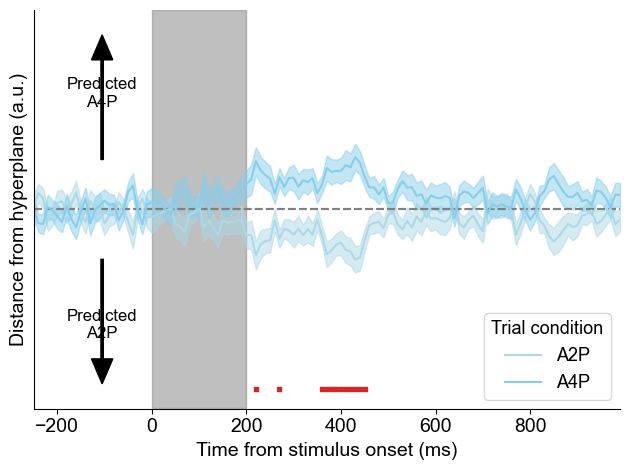

In [11]:
curr_conds = ['A2P', 'A4P']
cond_idx = [conditions.index(cond) for cond in curr_conds]
interp.confidence_scores = full_confidence_scores[:, :, :, cond_idx]
interp.colors = [color_map[cond] for cond in curr_conds]
interp.labels = curr_conds
fig = interp.plot_hyperplane(
    stim_time=[0,200],
    ylim=[-2,2],stim_label_xy=[130,3.1],label_text_ys=[-1,1],arrow_ys=[-.5,.5], train_labels=['A2P', 'A4P'],
    savefig=False,subtitle='Blank')

# add significance markers comparing the 2 conditions
MP_contrast = interp.confidence_scores[..., 1] - interp.confidence_scores[..., 0]
MP_contrast = MP_contrast.mean(axis=2) # mean across permutations

_, pvals = sista.ttest_1samp(MP_contrast, 0, axis=0, alternative="greater")
_, corrected_p, _, _ = multipletests(pvals, method='fdr_bh')
sig05 = corrected_p < 0.05
plt.scatter(
    interp.t[sig05],
    np.ones(sum(sig05))*-1.8,
    marker="s",
    s=10,
    c='tab:red'
)

plt.tight_layout()
plt.savefig(f'output/figures/{subtitle}_hyperplane.svg')

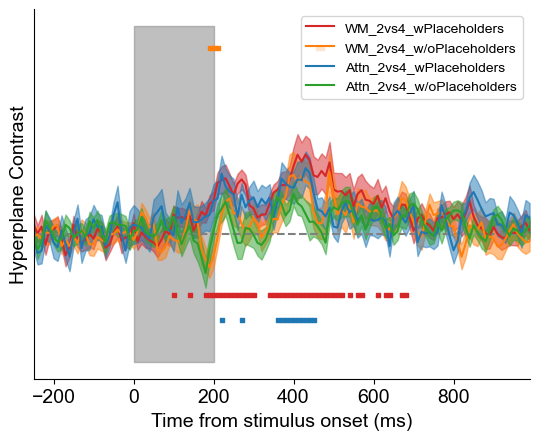

In [12]:
curr_conds = ['M2P', 'M4P', 'M2N', 'M4N', 'A2P', 'A4P', 'A2N', 'A4N']
cond_idx = [conditions.index(cond) for cond in curr_conds]
interp.confidence_scores = full_confidence_scores[:, :, :, cond_idx]
interp.colors = [color_map[cond] for cond in curr_conds]
interp.labels = curr_conds

MP_contrast = interp.confidence_scores[..., 1] - interp.confidence_scores[..., 0]
MP_contrast = MP_contrast.mean(axis=2) # mean across permutations

MN_contrast = interp.confidence_scores[..., 3] - interp.confidence_scores[..., 2]
MN_contrast = MN_contrast.mean(axis=2) # mean across permutations

AP_contrast = interp.confidence_scores[..., 5] - interp.confidence_scores[..., 4]
AP_contrast = AP_contrast.mean(axis=2) # mean across permutations

AN_contrast = interp.confidence_scores[..., 7] - interp.confidence_scores[..., 6]
AN_contrast = AN_contrast.mean(axis=2) # mean across permutations

ylim = [-2, 3.25]
stim_time = [0, 200]

cond_scores = [MP_contrast, MN_contrast, AP_contrast, AN_contrast]
labels = ['WM_2vs4_wPlaceholders', 'WM_2vs4_w/oPlaceholders', 'Attn_2vs4_wPlaceholders', 'Attn_2vs4_w/oPlaceholders']
color_palette = {'WM_2vs4_wPlaceholders': 'tab:red', 'WM_2vs4_w/oPlaceholders': 'tab:orange', 'Attn_2vs4_wPlaceholders': 'tab:blue', 'Attn_2vs4_w/oPlaceholders': 'tab:green'}

stim_lower = ylim[0]
stim_upper = ylim[1]

ax = plt.subplot(111)
ax.fill_between(
        stim_time, [stim_lower, stim_lower], [stim_upper, stim_upper], color="gray", alpha=0.5
    )

ax.plot(interp.t, np.zeros((len(interp.t))), "--", color="gray")

for i, curr_scores in enumerate(cond_scores):

    mean, upper, lower = interp.get_plot_line(curr_scores)
    ax.plot(interp.t, mean, color_palette[labels[i]], label=labels[i])
    ax.fill_between(interp.t, upper, lower, color=color_palette[labels[i]], alpha=0.5)

    _, ps = sista.ttest_1samp(curr_scores, 0, axis=0, alternative="greater")  # TODO: test against shuffled scores
    _, corrected_p, _, _ = multipletests(ps, method="fdr_bh")
    sig05 = corrected_p < 0.05
    plt.scatter(
        interp.t[sig05],
        np.ones(sum(sig05))*-.2*(i+1)-.75,
        marker="s",
        s=10,
        c=color_palette[labels[i]]
    )

# test if each of the last 3 scores are different from the 1 score

for i in range(1,4):

    _, ps = sista.ttest_rel(cond_scores[i], cond_scores[0], axis=0)  # TODO: test against shuffled scores
    _, corrected_p, _, _ = multipletests(ps, method="fdr_bh")
    sig05 = corrected_p < 0.05
    plt.scatter(
        interp.t[sig05],
        np.ones(sum(sig05))*.2*(i+1)+2.5,
        marker="s",
        s=10,
        c=color_palette[labels[i]]
    )

plt.yticks([])
plt.ylabel('Hyperplane Contrast', fontsize=14)
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('Time from stimulus onset (ms)', fontsize=14)
plt.xlim(-250, max(interp.t))

sns.despine()
_ = plt.legend()
plt.savefig(f'output/figures/{subtitle}_contrasts.svg', format='svg')

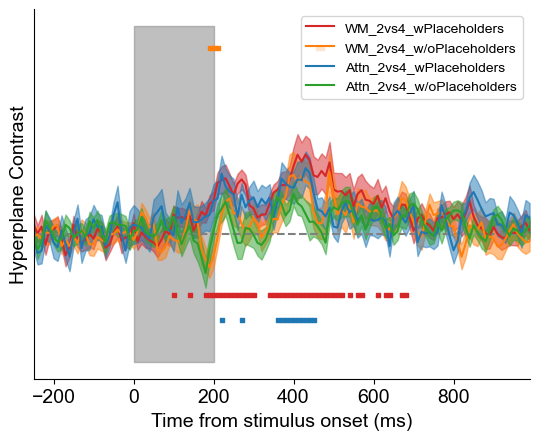

In [13]:
curr_conds = ['M2P', 'M4P', 'M2N', 'M4N', 'A2P', 'A4P', 'A2N', 'A4N']
cond_idx = [conditions.index(cond) for cond in curr_conds]
interp.confidence_scores = full_confidence_scores[:, :, :, cond_idx]
interp.colors = [color_map[cond] for cond in curr_conds]
interp.labels = curr_conds

MP_contrast = interp.confidence_scores[..., 1] - interp.confidence_scores[..., 0]
MP_contrast = MP_contrast.mean(axis=2) # mean across permutations

MN_contrast = interp.confidence_scores[..., 3] - interp.confidence_scores[..., 2]
MN_contrast = MN_contrast.mean(axis=2) # mean across permutations

AP_contrast = interp.confidence_scores[..., 5] - interp.confidence_scores[..., 4]
AP_contrast = AP_contrast.mean(axis=2) # mean across permutations

AN_contrast = interp.confidence_scores[..., 7] - interp.confidence_scores[..., 6]
AN_contrast = AN_contrast.mean(axis=2) # mean across permutations

ylim = [-2, 3.25]
stim_time = [0, 200]

cond_scores = [MP_contrast, MN_contrast, AP_contrast, AN_contrast]
labels = ['WM_2vs4_wPlaceholders', 'WM_2vs4_w/oPlaceholders', 'Attn_2vs4_wPlaceholders', 'Attn_2vs4_w/oPlaceholders']
color_palette = {'WM_2vs4_wPlaceholders': 'tab:red', 'WM_2vs4_w/oPlaceholders': 'tab:orange', 'Attn_2vs4_wPlaceholders': 'tab:blue', 'Attn_2vs4_w/oPlaceholders': 'tab:green'}

stim_lower = ylim[0]
stim_upper = ylim[1]

ax = plt.subplot(111)
ax.fill_between(
        stim_time, [stim_lower, stim_lower], [stim_upper, stim_upper], color="gray", alpha=0.5
    )

ax.plot(interp.t, np.zeros((len(interp.t))), "--", color="gray")

for i, curr_scores in enumerate(cond_scores):

    mean, upper, lower = interp.get_plot_line(curr_scores)
    ax.plot(interp.t, mean, color_palette[labels[i]], label=labels[i])
    ax.fill_between(interp.t, upper, lower, color=color_palette[labels[i]], alpha=0.5)

    _, ps = sista.ttest_1samp(curr_scores, 0, axis=0, alternative="greater")  # TODO: test against shuffled scores
    _, corrected_p, _, _ = multipletests(ps, method="fdr_bh")
    sig05 = corrected_p < 0.05
    plt.scatter(
        interp.t[sig05],
        np.ones(sum(sig05))*-.2*(i+1)-.75,
        marker="s",
        s=10,
        c=color_palette[labels[i]]
    )

# test if each of the last 3 scores are different from the 1 score

for i in range(1,4):

    _, ps = sista.ttest_rel(cond_scores[i], cond_scores[0], axis=0)  # TODO: test against shuffled scores
    _, corrected_p, _, _ = multipletests(ps, method="fdr_bh")
    sig05 = corrected_p < 0.05
    plt.scatter(
        interp.t[sig05],
        np.ones(sum(sig05))*.2*(i+1)+2.5,
        marker="s",
        s=10,
        c=color_palette[labels[i]]
    )

plt.yticks([])
plt.ylabel('Hyperplane Contrast', fontsize=14)
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('Time from stimulus onset (ms)', fontsize=14)
plt.xlim(-250, max(interp.t))

sns.despine()
_ = plt.legend()
plt.savefig(f'output/figures/{subtitle}_contrasts.svg', format='svg')

In [14]:
MP_df = pd.DataFrame(MP_contrast[:, interp.t>200].mean(1), columns=['Hyperplane Contrast'])
MP_df['Task'] = 'WM'
MP_df['Placeholder'] = True
MP_df['subject'] = MP_df.index
MP_df['color_name'] = 'WM_2vs4_wPlaceholders'

MN_df = pd.DataFrame(MN_contrast[:, interp.t>200].mean(1), columns=['Hyperplane Contrast'])
MN_df['Task'] = 'WM'
MN_df['Placeholder'] = False
MN_df['subject'] = MN_df.index
MN_df['color_name'] = 'WM_2vs4_w/oPlaceholders'

AP_df = pd.DataFrame(AP_contrast[:, interp.t>200].mean(1), columns=['Hyperplane Contrast'])
AP_df['Task'] = 'Attention'
AP_df['Placeholder'] = True
AP_df['subject'] = AP_df.index
AP_df['color_name'] = 'Attn_2vs4_wPlaceholders'

AN_df = pd.DataFrame(AN_contrast[:, interp.t>200].mean(1), columns=['Hyperplane Contrast'])
AN_df['Task'] = 'Attention'
AN_df['Placeholder'] = False
AN_df['subject'] = AN_df.index
AN_df['color_name'] = 'Attn_2vs4_w/oPlaceholders'

all_df = pd.concat([MP_df, MN_df, AP_df, AN_df])
all_df


,Hyperplane Contrast,Task,Placeholder,subject,color_name
0,0.667088,WM,True,0,WM_2vs4_wPlaceholders
1,0.129293,WM,True,1,WM_2vs4_wPlaceholders
2,0.858403,WM,True,2,WM_2vs4_wPlaceholders
3,0.566750,WM,True,3,WM_2vs4_wPlaceholders
4,0.190406,WM,True,4,WM_2vs4_wPlaceholders
...,...,...,...,...,...
21,0.216701,Attention,False,21,Attn_2vs4_w/oPlaceholders
22,0.088429,Attention,False,22,Attn_2vs4_w/oPlaceholders
23,-0.274090,Attention,False,23,Attn_2vs4_w/oPlaceholders
24,0.059238,Attention,False,24,Attn_2vs4_w/oPlaceholders


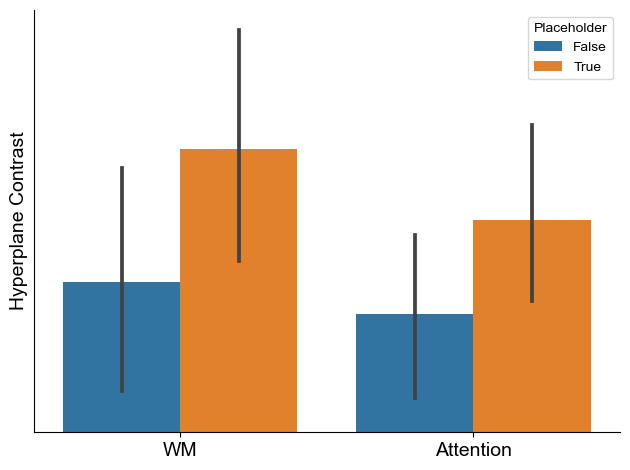

In [15]:
_ = sns.barplot(x=all_df['Task'], y=all_df['Hyperplane Contrast'], hue=all_df['Placeholder'])
sns.despine()
plt.yticks([])
plt.ylabel('Hyperplane Contrast', fontsize=14)
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('')

plt.tight_layout()
plt.savefig(f'output/figures/{subtitle}_ANOVA_barplot.svg', format='svg')

In [16]:
import pingouin as pg

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [17]:
pg.rm_anova(all_df, dv='Hyperplane Contrast', within=['Task', 'Placeholder'], subject='subject')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Task,0.194103,1,25,0.194103,0.991353,0.328952,0.328952,0.009338,1.0
1,Placeholder,0.949423,1,25,0.949423,5.968663,0.021966,0.021966,0.044073,1.0
2,Task * Placeholder,0.026981,1,25,0.026981,0.214619,0.647179,0.647179,0.001309,1.0


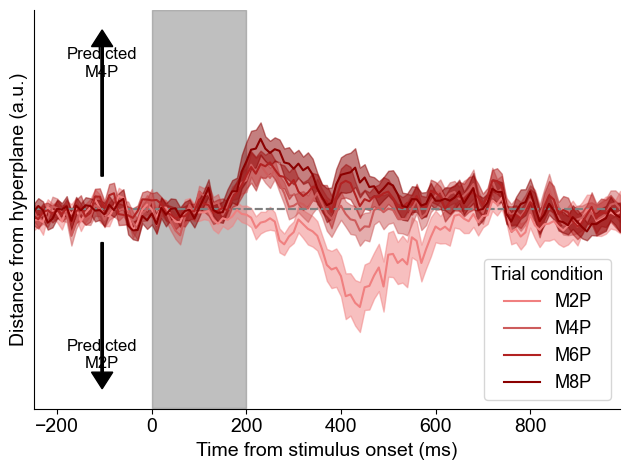

In [18]:
curr_conds = ['M2P', 'M4P', 'M6P', 'M8P']
cond_idx = [conditions.index(cond) for cond in curr_conds]
interp.confidence_scores = full_confidence_scores[:, :, :, cond_idx]
interp.colors = [color_map[cond] for cond in curr_conds]
interp.labels = curr_conds
interp.plot_hyperplane(
    stim_time=[0,200],
    ylim=[-3,3],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5], train_labels=['M2P', 'M4P'],
    savefig=False,subtitle='Blank')


plt.show()
plt.close()

1 8.441327098070635e-05
2 3.775323574029535e-05
3 1.2438422564656262e-05
2 0.24109883172582872
3 0.021179631893401267


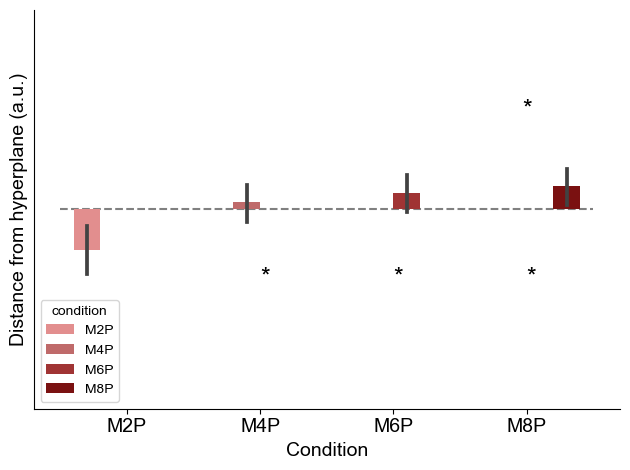

In [19]:
# building up to barplots across the average delay period
curr_cs = interp.confidence_scores.mean(2)
curr_cs = curr_cs[:, interp.t>200, :].mean(1)
curr_cs.shape
full_df = pd.DataFrame(curr_cs, columns=curr_conds)
full_df['subject'] = full_df.index.values
melted_df = full_df.melt(id_vars='subject', var_name='condition', value_name='distance')
melted_df
# plt.plot(, np.zeros((len(interp.t))), "--", color="gray")
ax = sns.barplot(data=melted_df, x='condition', y='distance', hue='condition', palette=color_map)
ax.hlines(0, -0.5, 3.5, color='gray', linestyle='--', zorder=-1)

# Add t-tests agains the first 2 conditions
# test cond 0 against the other 1-3
for i in range(1,4):
    _, p = sista.ttest_rel(curr_cs[:, i], curr_cs[:, 0], axis=0)
    print(i, p)
    if p<0.05:
        plt.text(i, -.75, '*', fontsize=18)

    if (p>=.05) & (p<.1):
        plt.text(i, 1.5, '+', fontsize=18)

# test cond 1 against 2-3
for i in range(2,4):
    _, p = sista.ttest_rel(curr_cs[:, i], curr_cs[:, 1], axis=0)
    print(i, p)
    if p<0.05:
        plt.text(i, 1, '*', fontsize=18, ha='center', va='center')

    if (p>=.05) & (p<.1):
        plt.text(i, 1.25, '+', fontsize=18, ha='center', va='center')

# get rid of yticks and labels
plt.ylim(-2, 2)
_ = plt.yticks([])
_ = plt.ylabel('Distance from hyperplane (a.u.)', fontsize=14)
# change xticks fontsize
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('Condition', fontsize=14)

_ = sns.despine()
plt.tight_layout()
# plt.savefig(f'output/figures/{subtitle}_delay_period.svg')  
plt.show()
plt.close()

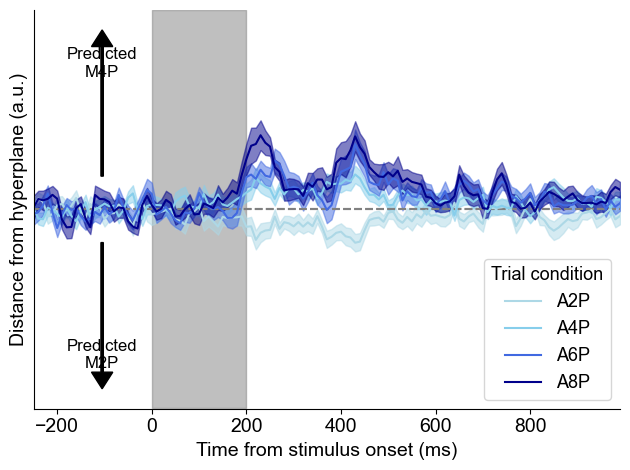

In [20]:
curr_conds = ['A2P', 'A4P', 'A6P', 'A8P']
cond_idx = [conditions.index(cond) for cond in curr_conds]
interp.confidence_scores = full_confidence_scores[:, :, :, cond_idx]
interp.colors = [color_map[cond] for cond in curr_conds]
interp.labels = curr_conds
interp.plot_hyperplane(
    stim_time=[0,200],
    ylim=[-3,3],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5], train_labels=['M2P', 'M4P'],
    savefig=False,subtitle='Blank')


plt.show()
plt.close()

1 0.00014218043572160316
2 1.1964736976952442e-05
3 2.3318590817247444e-06
2 0.2239335193635721
3 0.02404282671616602


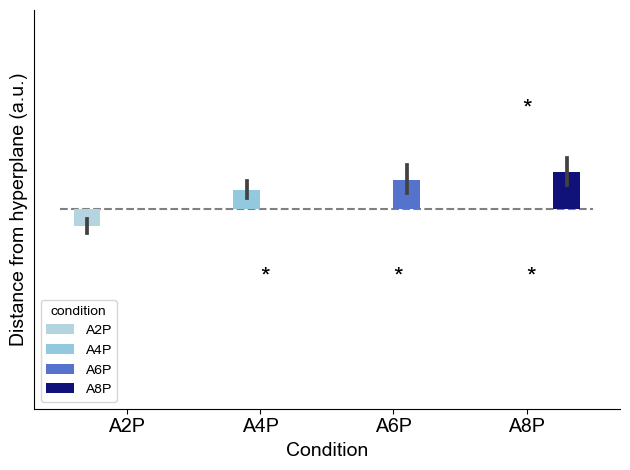

In [21]:
# building up to barplots across the average delay period
curr_cs = interp.confidence_scores.mean(2)
curr_cs = curr_cs[:, interp.t>200, :].mean(1)
curr_cs.shape
full_df = pd.DataFrame(curr_cs, columns=curr_conds)
full_df['subject'] = full_df.index.values
melted_df = full_df.melt(id_vars='subject', var_name='condition', value_name='distance')
melted_df
# plt.plot(, np.zeros((len(interp.t))), "--", color="gray")
ax = sns.barplot(data=melted_df, x='condition', y='distance', hue='condition', palette=color_map)
ax.hlines(0, -0.5, 3.5, color='gray', linestyle='--', zorder=-1)

# Add t-tests agains the first 2 conditions
# test cond 0 against the other 1-3
for i in range(1,4):
    _, p = sista.ttest_rel(curr_cs[:, i], curr_cs[:, 0], axis=0)
    print(i, p)
    if p<0.05:
        plt.text(i, -.75, '*', fontsize=18)

    if (p>=.05) & (p<.1):
        plt.text(i, 1.5, '+', fontsize=18)

# test cond 1 against 2-3
for i in range(2,4):
    _, p = sista.ttest_rel(curr_cs[:, i], curr_cs[:, 1], axis=0)
    print(i, p)
    if p<0.05:
        plt.text(i, 1, '*', fontsize=18, ha='center', va='center')

    if (p>=.05) & (p<.1):
        plt.text(i, 1.25, '+', fontsize=18, ha='center', va='center')

# get rid of yticks and labels
plt.ylim(-2, 2)
_ = plt.yticks([])
_ = plt.ylabel('Distance from hyperplane (a.u.)', fontsize=14)
# change xticks fontsize
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('Condition', fontsize=14)

_ = sns.despine()
plt.tight_layout()
plt.savefig(f'output/figures/{subtitle}_delay_period.svg')  
plt.show()
plt.close()

# just checking what the other conditions look like on the original hyperplanes

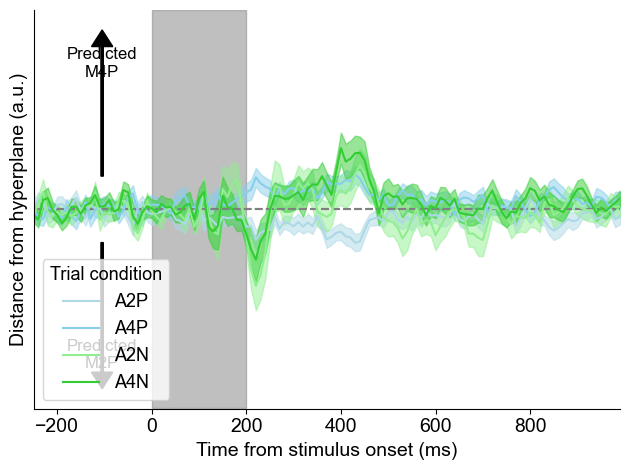

In [22]:
curr_conds = ['A2P', 'A4P', 'A2N', 'A4N']
cond_idx = [conditions.index(cond) for cond in curr_conds]
interp.confidence_scores = full_confidence_scores[:, :, :, cond_idx]
interp.colors = [color_map[cond] for cond in curr_conds]
interp.labels = curr_conds
interp.plot_hyperplane(
    stim_time=[0,200],
    ylim=[-3,3],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5], train_labels=['M2P', 'M4P'],
    savefig=False,subtitle='Blank',legend_pos='lower left')
plt.show()
plt.close()

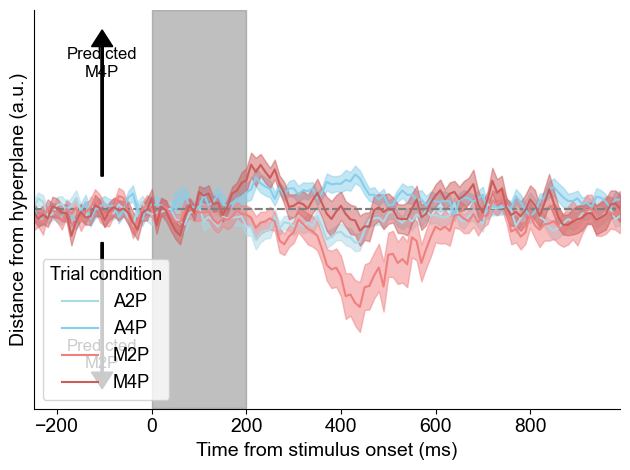

In [23]:
curr_conds = ['A2P', 'A4P', 'M2P', 'M4P']
cond_idx = [conditions.index(cond) for cond in curr_conds]
interp.confidence_scores = full_confidence_scores[:, :, :, cond_idx]
interp.colors = [color_map[cond] for cond in curr_conds]
interp.labels = curr_conds
interp.plot_hyperplane(
    stim_time=[0,200],
    ylim=[-3,3],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5], train_labels=['M2P', 'M4P'],
    savefig=False,subtitle='Blank',legend_pos='lower left')
plt.show()
plt.close()

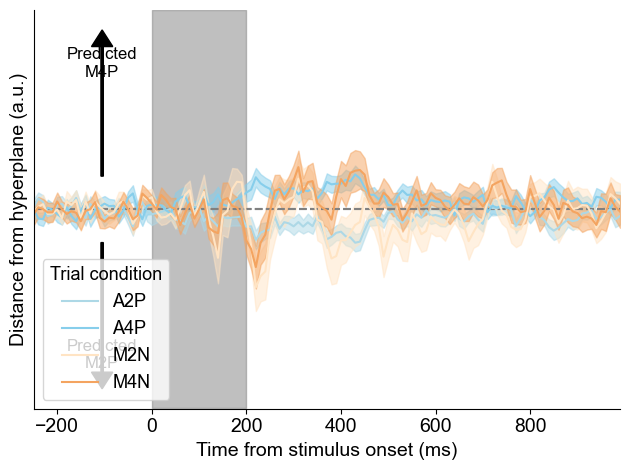

In [24]:
curr_conds = ['A2P', 'A4P', 'M2N', 'M4N']
cond_idx = [conditions.index(cond) for cond in curr_conds]
interp.confidence_scores = full_confidence_scores[:, :, :, cond_idx]
interp.colors = [color_map[cond] for cond in curr_conds]
interp.labels = curr_conds
interp.plot_hyperplane(
    stim_time=[0,200],
    ylim=[-3,3],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5], train_labels=['M2P', 'M4P'],
    savefig=False,subtitle='Blank',legend_pos='lower left')
plt.show()
plt.close()

# Scatter plot comparing M2P-M4P axis against A2P-A4P axis

In [25]:
attn_confidences = full_confidence_scores.mean(2) # mean across permutations
attn_confidences = attn_confidences[:, interp.t>200, :].mean(1) # mean across delay period
attn_confidences = attn_confidences.mean(0) # mean across subjects
attn_confidences.shape

(16,)

In [26]:
interp_WM = eeg_decoder.Interpreter()
interp_WM.load_results('WM_2vs4_wP')
wm_confidences = np.copy(interp_WM.confidence_scores).mean(2)
wm_confidences = wm_confidences[:, interp_WM.t>200, :].mean(1)
wm_confidences = wm_confidences.mean(0)
wm_confidences.shape

(16,)

In [27]:
conditions = ["M2N", "M4N", "M6N", "M8N", "M2P", "M4P", "M6P", "M8P", "A2N", "A4N", "A6N", "A8N", "A2P", "A4P", "A6P", "A8P"]

In [28]:
labels = ['WM_w/oPlaceholders']*4 + ['WM_wPlaceholders'] * 4 + ['Attn_w/oPlaceholders']*4 + ['Attn_wPlaceholders']*4
color_palette = {'WM_wPlaceholders': 'tab:red', 'WM_w/oPlaceholders': 'tab:orange', 'Attn_wPlaceholders': 'tab:blue', 'Attn_w/oPlaceholders': 'tab:green'}

setsize = [2, 4, 6, 8]*4

In [29]:
scatter_df = pd.DataFrame({'condition': labels, 'setsize': setsize, 'WM 2 - WM 4 (w/Placeholder) axis': wm_confidences, 'Attention 2 - Attention 4 (w/Placeholder) axis': attn_confidences})

In [30]:
scatter_df

,condition,setsize,WM 2 - WM 4 (w/Placeholder) axis,Attention 2 - Attention 4 (w/Placeholder) axis
0,WM_w/oPlaceholders,2,-0.350217,-0.149233
1,WM_w/oPlaceholders,4,0.613154,0.102989
2,WM_w/oPlaceholders,6,1.187655,0.326239
3,WM_w/oPlaceholders,8,0.982200,0.130160
4,WM_wPlaceholders,2,-0.607013,-0.405523
5,WM_wPlaceholders,4,0.553532,0.070005
6,WM_wPlaceholders,6,0.901797,0.162921
7,WM_wPlaceholders,8,0.960320,0.229609
8,Attn_w/oPlaceholders,2,0.381736,-0.046498
9,Attn_w/oPlaceholders,4,0.640311,0.151534


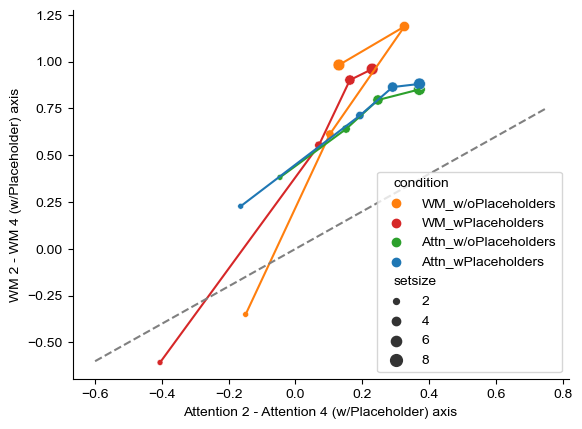

In [31]:
_ = sns.scatterplot(data=scatter_df, x='Attention 2 - Attention 4 (w/Placeholder) axis', y='WM 2 - WM 4 (w/Placeholder) axis', hue='condition', palette=color_palette, size='setsize')

# add a colored line for each condition
for cond in scatter_df['condition'].unique():
    curr_df = scatter_df.loc[scatter_df['condition']==cond]
    plt.plot(curr_df['Attention 2 - Attention 4 (w/Placeholder) axis'], curr_df['WM 2 - WM 4 (w/Placeholder) axis'], color=color_palette[cond])

# add slope=1 gray line
plt.plot([-.6, .75], [-.6, .75], color='gray', linestyle='--')

sns.despine()
plt.show()
plt.close()

In [32]:
sub_ids = [xfile.split('/')[-2] for xfile in sub_files]

attn_confidences = full_confidence_scores.mean(2) # mean across permutations
attn_confidences = attn_confidences[:, interp.t>200, :].mean(1) # mean across delay period

interp_WM = eeg_decoder.Interpreter()
interp_WM.load_results('WM_2vs4_wP')
wm_confidences = np.copy(interp_WM.confidence_scores).mean(2)
wm_confidences = wm_confidences[:, interp_WM.t>200, :].mean(1)

pop_df = pd.DataFrame()
for isub, sub_id in enumerate(sub_ids):
    sub_df = pd.DataFrame({'condition': labels, 'setsize': setsize, 'WM 2 - WM 4 (w/Placeholder) axis': wm_confidences[isub], 'Attention 2 - Attention 4 (w/Placeholder) axis': attn_confidences[isub]})
    sub_df['subject'] = sub_id
    pop_df = pd.concat([pop_df, sub_df])

pop_df

,condition,setsize,WM 2 - WM 4 (w/Placeholder) axis,Attention 2 - Attention 4 (w/Placeholder) axis,subject
0,WM_w/oPlaceholders,2,-0.670398,-1.809571,001
1,WM_w/oPlaceholders,4,-0.196384,-1.006818,001
2,WM_w/oPlaceholders,6,0.537298,-0.305433,001
3,WM_w/oPlaceholders,8,0.500428,-0.634411,001
4,WM_wPlaceholders,2,-0.740819,-1.693720,001
...,...,...,...,...,...
11,Attn_w/oPlaceholders,8,-0.026730,0.466802,034
12,Attn_wPlaceholders,2,-0.674116,-0.035544,034
13,Attn_wPlaceholders,4,0.123499,0.086491,034
14,Attn_wPlaceholders,6,-0.127562,0.352694,034


In [33]:
import statsmodels.api as sm

In [34]:
WM_subset_df = pop_df[pop_df['condition'].str.contains('WM')].copy()
WM_subset_df['intercept'] = 1

sm.OLS(WM_subset_df['WM 2 - WM 4 (w/Placeholder) axis'], WM_subset_df.loc[:, ['Attention 2 - Attention 4 (w/Placeholder) axis', 'intercept']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     WM 2 - WM 4 (w/Placeholder) axis   R-squared:                       0.137
Model:                                          OLS   Adj. R-squared:                  0.133
Method:                               Least Squares   F-statistic:                     32.69
Date:                              Wed, 24 Jul 2024   Prob (F-statistic):           3.76e-08
Time:                                      09:45:03   Log-Likelihood:                -245.70
No. Observations:                               208   AIC:                             495.4
Df Residuals:                                   206   BIC:                             502.1
Df Model:                                         1                                         
Covariance Type:                          nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Attention 2 - Attention 4 (w/Placeholder) axis     0.5295      0.093      5.718      0.000       0.347       0.712
intercept                                          0.4993      0.055      9.045      0.000       0.390       0.608
==============================================================================
Omnibus:                        0.242   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.886   Jarque-Bera (JB):                0.144
Skew:                          -0.063   Prob(JB):                        0.931
Kurtosis:                       3.023   Cond. No.                         1.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
Attn_subset_df = pop_df[pop_df['condition'].str.contains('Attn')].copy()
Attn_subset_df['intercept'] = 1

sm.OLS(Attn_subset_df['WM 2 - WM 4 (w/Placeholder) axis'], Attn_subset_df.loc[:, ['Attention 2 - Attention 4 (w/Placeholder) axis', 'intercept']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     WM 2 - WM 4 (w/Placeholder) axis   R-squared:                       0.033
Model:                                          OLS   Adj. R-squared:                  0.028
Method:                               Least Squares   F-statistic:                     7.044
Date:                              Wed, 24 Jul 2024   Prob (F-statistic):            0.00858
Time:                                      09:45:03   Log-Likelihood:                -234.80
No. Observations:                               208   AIC:                             473.6
Df Residuals:                                   206   BIC:                             480.3
Df Model:                                         1                                         
Covariance Type:                          nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Attention 2 - Attention 4 (w/Placeholder) axis     0.3199      0.121      2.654      0.009       0.082       0.558
intercept                                          0.6127      0.056     10.880      0.000       0.502       0.724
==============================================================================
Omnibus:                        2.266   Durbin-Watson:                   0.862
Prob(Omnibus):                  0.322   Jarque-Bera (JB):                1.937
Skew:                          -0.224   Prob(JB):                        0.380
Kurtosis:                       3.150   Cond. No.                         2.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# repeat using just the condition averages

In [36]:
pop_df[pop_df['condition'].str.contains('WM')]

,condition,setsize,WM 2 - WM 4 (w/Placeholder) axis,Attention 2 - Attention 4 (w/Placeholder) axis,subject
0,WM_w/oPlaceholders,2,-0.670398,-1.809571,001
1,WM_w/oPlaceholders,4,-0.196384,-1.006818,001
2,WM_w/oPlaceholders,6,0.537298,-0.305433,001
3,WM_w/oPlaceholders,8,0.500428,-0.634411,001
4,WM_wPlaceholders,2,-0.740819,-1.693720,001
...,...,...,...,...,...
3,WM_w/oPlaceholders,8,0.902391,0.624084,034
4,WM_wPlaceholders,2,-0.851195,-0.285482,034
5,WM_wPlaceholders,4,0.838971,0.223139,034
6,WM_wPlaceholders,6,1.179133,0.515215,034


In [37]:
WM_subset_df = pop_df[pop_df['condition'].str.contains('WM')].groupby(['condition', 'setsize']).mean().reset_index()
WM_subset_df['intercept'] = 1

sm.OLS(WM_subset_df['WM 2 - WM 4 (w/Placeholder) axis'], WM_subset_df.loc[:, ['Attention 2 - Attention 4 (w/Placeholder) axis', 'intercept']]).fit().summary()

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     WM 2 - WM 4 (w/Placeholder) axis   R-squared:                       0.935
Model:                                          OLS   Adj. R-squared:                  0.925
Method:                               Least Squares   F-statistic:                     86.72
Date:                              Wed, 24 Jul 2024   Prob (F-statistic):           8.68e-05
Time:                                      09:45:03   Log-Likelihood:                 3.4763
No. Observations:                                 8   AIC:                            -2.953
Df Residuals:                                     6   BIC:                            -2.794
Df Model:                                         1                                         
Covariance Type:                          nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Attention 2 - Attention 4 (w/Placeholder) axis     2.7421      0.294      9.313      0.000       2.022       3.463
intercept                                          0.3701      0.066      5.587      0.001       0.208       0.532
==============================================================================
Omnibus:                        1.208   Durbin-Watson:                   1.247
Prob(Omnibus):                  0.547   Jarque-Bera (JB):                0.172
Skew:                          -0.357   Prob(JB):                        0.917
Kurtosis:                       2.909   Cond. No.                         4.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
Attn_subset_df = pop_df[pop_df['condition'].str.contains('Attn')].copy().groupby(['condition', 'setsize']).mean().reset_index()
Attn_subset_df['intercept'] = 1

sm.OLS(Attn_subset_df['WM 2 - WM 4 (w/Placeholder) axis'], Attn_subset_df.loc[:, ['Attention 2 - Attention 4 (w/Placeholder) axis', 'intercept']]).fit().summary()

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     WM 2 - WM 4 (w/Placeholder) axis   R-squared:                       0.977
Model:                                          OLS   Adj. R-squared:                  0.973
Method:                               Least Squares   F-statistic:                     250.5
Date:                              Wed, 24 Jul 2024   Prob (F-statistic):           4.04e-06
Time:                                      09:45:03   Log-Likelihood:                 15.531
No. Observations:                                 8   AIC:                            -27.06
Df Residuals:                                     6   BIC:                            -26.90
Df Model:                                         1                                         
Covariance Type:                          nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Attention 2 - Attention 4 (w/Placeholder) axis     1.2437      0.079     15.827      0.000       1.051       1.436
intercept                                          0.4494      0.020     22.649      0.000       0.401       0.498
==============================================================================
Omnibus:                        0.120   Durbin-Watson:                   2.301
Prob(Omnibus):                  0.942   Jarque-Bera (JB):                0.324
Skew:                          -0.064   Prob(JB):                        0.850
Kurtosis:                       2.022   Cond. No.                         5.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
ols_df = pop_df.groupby(['condition', 'setsize']).mean().reset_index()
# add an intercept per condition
ols_df['int_ATTN_np'] = 0
ols_df.loc[ols_df['condition']=='Attn_w/oPlaceholders', 'int_ATTN_np'] = 1
ols_df['int_ATTN_p'] = 0
ols_df.loc[ols_df['condition']=='Attn_wPlaceholders', 'int_ATTN_p'] = 1
ols_df['int_WM_np'] = 0
ols_df.loc[ols_df['condition']=='WM_w/oPlaceholders', 'int_WM_np'] = 1
ols_df['int_WM_p'] = 0
ols_df.loc[ols_df['condition']=='WM_wPlaceholders', 'int_WM_p'] = 1

# add interaction between task and Attn axis
ols_df['int_ATTN_np*WM'] = (ols_df['int_WM_np']+ols_df['int_WM_p']) * ols_df['Attention 2 - Attention 4 (w/Placeholder) axis']


ols_df

,condition,setsize,WM 2 - WM 4 (w/Placeholder) axis,Attention 2 - Attention 4 (w/Placeholder) axis,int_ATTN_np,int_ATTN_p,int_WM_np,int_WM_p,int_ATTN_np*WM
0,Attn_w/oPlaceholders,2,0.381736,-0.046498,1,0,0,0,-0.000000
1,Attn_w/oPlaceholders,4,0.640311,0.151534,1,0,0,0,0.000000
2,Attn_w/oPlaceholders,6,0.795159,0.246926,1,0,0,0,0.000000
3,Attn_w/oPlaceholders,8,0.851602,0.370849,1,0,0,0,0.000000
4,Attn_wPlaceholders,2,0.227582,-0.164089,0,1,0,0,-0.000000
5,Attn_wPlaceholders,4,0.712150,0.192822,0,1,0,0,0.000000
6,Attn_wPlaceholders,6,0.864232,0.290869,0,1,0,0,0.000000
7,Attn_wPlaceholders,8,0.881010,0.371256,0,1,0,0,0.000000
8,WM_w/oPlaceholders,2,-0.350217,-0.149233,0,0,1,0,-0.149233
9,WM_w/oPlaceholders,4,0.613154,0.102989,0,0,1,0,0.102989


In [40]:
sm.OLS(ols_df['WM 2 - WM 4 (w/Placeholder) axis'], ols_df.loc[:, ['Attention 2 - Attention 4 (w/Placeholder) axis', 'int_ATTN_np', 'int_ATTN_p', 'int_WM_np', 'int_WM_p', 'int_ATTN_np*WM']]).fit().summary()

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     WM 2 - WM 4 (w/Placeholder) axis   R-squared:                       0.946
Model:                                          OLS   Adj. R-squared:                  0.919
Method:                               Least Squares   F-statistic:                     35.06
Date:                              Wed, 24 Jul 2024   Prob (F-statistic):           5.01e-06
Time:                                      09:45:03   Log-Likelihood:                 12.754
No. Observations:                                16   AIC:                            -13.51
Df Residuals:                                    10   BIC:                            -8.872
Df Model:                                         5                                         
Covariance Type:                          nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Attention 2 - Attention 4 (w/Placeholder) axis     1.2446      0.270      4.603      0.001       0.642       1.847
int_ATTN_np                                        0.4423      0.085      5.233      0.000       0.254       0.631
int_ATTN_p                                         0.4563      0.083      5.479      0.000       0.271       0.642
int_WM_np                                          0.3227      0.073      4.430      0.001       0.160       0.485
int_WM_p                                           0.4125      0.069      5.975      0.000       0.259       0.566
int_ATTN_np*WM                                     1.5395      0.354      4.343      0.001       0.750       2.329
==============================================================================
Omnibus:                        6.752   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                4.715
Skew:                           0.458   Prob(JB):                       0.0946
Kurtosis:                       5.497   Cond. No.                         6.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Repeat just looking at the last 200ms

In [42]:
interp = eeg_decoder.Interpreter()
interp.load_results(subtitle)
full_confidence_scores = np.copy(interp.confidence_scores)
attn_confidences = full_confidence_scores.mean(2) # mean across permutations
attn_confidences = attn_confidences[:, interp.t>800, :].mean(1) # mean across delay period
attn_confidences = attn_confidences.mean(0) # mean across subjects
attn_confidences.shape


interp_WM = eeg_decoder.Interpreter()
interp_WM.load_results('WM_2vs4_wP')
wm_confidences = np.copy(interp_WM.confidence_scores).mean(2)
wm_confidences = wm_confidences[:, interp_WM.t>800, :].mean(1)
wm_confidences = wm_confidences.mean(0)
wm_confidences.shape

(16,)

In [43]:
scatter_df = pd.DataFrame({'condition': labels, 'setsize': setsize, 'WM 2 - WM 4 (w/Placeholder) axis': wm_confidences, 'Attention 2 - Attention 4 (w/Placeholder) axis': attn_confidences})

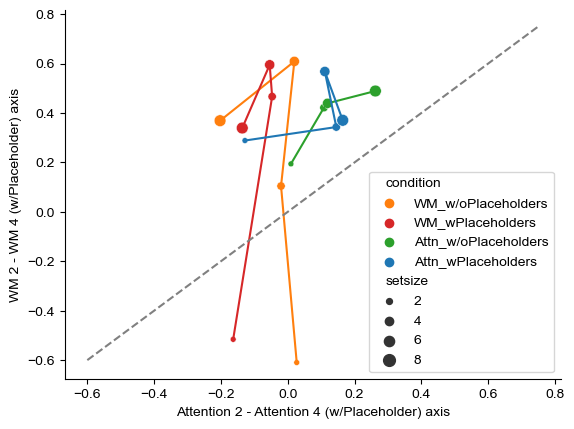

In [44]:
_ = sns.scatterplot(data=scatter_df, x='Attention 2 - Attention 4 (w/Placeholder) axis', y='WM 2 - WM 4 (w/Placeholder) axis', hue='condition', palette=color_palette, size='setsize')

# add a colored line for each condition
for cond in scatter_df['condition'].unique():
    curr_df = scatter_df.loc[scatter_df['condition']==cond]
    plt.plot(curr_df['Attention 2 - Attention 4 (w/Placeholder) axis'], curr_df['WM 2 - WM 4 (w/Placeholder) axis'], color=color_palette[cond])

# add slope=1 gray line
plt.plot([-.6, .75], [-.6, .75], color='gray', linestyle='--')

sns.despine()
plt.show()
plt.close()